In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

from icecream import ic

In [2]:
conditions_df = pd.read_csv("conditions_df.csv")
conditions_df.head()

,time,TAN_DF,pH_DF,NO2_DF,Alkalinity_DF,TAN_DGS,pH_DGS,NO2_DGS,Alkalinity_DGS,Flow_rate,...,TAN_removal_biocarrier,co2_mgl,h2s_ugl,o2_mgl,o2_sat,salinity,temp,sample_name,System,TimeStamp
0,29/08/2022 08:30,0.24,7.880,0.64,342.4,0.18,7.860,0.71,344.0,60.0,...,0.000034,7.03,0.16,7.79,83.78,14.88,15.1,B1_1,B,1
1,29/08/2022 08:31,0.28,8.070,0.64,433.4,0.22,8.020,0.55,433.9,60.0,...,0.000038,4.93,0.32,8.41,89.33,13.02,15.1,A1_1,A,1
2,05/09/2022 08:30,0.16,7.600,0.46,234.0,0.12,7.900,0.62,234.0,60.0,...,0.000023,8.76,0.13,7.57,81.98,16.36,15.3,B1_2,B,2
3,05/09/2022 08:31,0.15,7.700,0.46,233.4,0.04,8.000,0.35,232.0,60.0,...,0.000070,7.61,0.20,8.20,86.99,13.89,15.0,A1_2,A,2
4,12/09/2022 08:30,0.16,7.565,0.27,204.4,0.09,7.828,0.22,218.3,60.0,...,0.000050,9.08,0.11,7.40,82.05,16.98,15.2,B1_3,B,3


In [3]:
species_df = pd.read_csv("sample_by_specie_timewise.csv")
species_df.fillna(0,inplace=True)
species_df.head()

,id,Specie,System,Treatment,Replica,t1,t2,t3,slope,var,std,mean
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947,0.284809,0.064824,0.254606,0.473834
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915,0.311519,0.072147,0.268602,0.569359
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994,0.222476,0.033018,0.181708,0.511723
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,0.000000,-0.320513,0.084277,0.290305,0.409370
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,0.000000,-0.364964,0.095881,0.309646,0.424468


In [4]:
species_df["slope"].mean()

-0.00291974212837522

Remove rows with value 0

In [5]:
species_df = species_df[species_df["slope"] != 0.0]

In [6]:
species_df["slope"].mean()

-0.07209545438160118

In [7]:
columns =["TAN_DF","NO2_DF","TAN_DGS","NO2_DGS","TAN_removal_biocarrier","co2_mgl","h2s_ugl"]

In [8]:
import itertools
class Dataset():
    def __init__(self, species_df, conditions):
        self.species_df = species_df
        self.conditions = conditions

        #diferent species
        self.species_vocab = species_df["Specie"].unique().tolist()
        self.treatments_vocab = species_df["Treatment"].unique().tolist()
        self.system_vocab = species_df["System"].unique().tolist()
        self.combinations = [f"{system}_{treatment}" for system in self.system_vocab for treatment in self.treatments_vocab]
        
    def __len__(self):
        return len(self.species_df)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < self.__len__())), "Dataset index out of range"

        row =  self.species_df.iloc[idx]
        one_hot_specie = self.species_vocab.index(row["Specie"]) #one hot specie

        cond_by_t = []
        for t in range(1,4):
            conditions = self.conditions[(self.conditions["System"] == row["System"]) & (self.conditions["Treatment"] == row["Treatment"]) & (self.conditions["TimeStamp"] == t)][columns]
            if len(conditions) == 0:
                cond_by_t.append([0]*len(columns))
            else:
                cond_by_t.append(conditions.iloc[0].tolist())
        
        #compute the slope of each cond_by_t
        cond_by_t = np.array(cond_by_t)

        slopes = np.diff(cond_by_t, axis=0)  # Take the differences along the first axis (axis=0)
        slopes = slopes.mean(axis=0, keepdims=True)  # Calculate the mean along the first axis to get shape (1, 20)
        
        encoding = str(row["System"]) + "_" + str(row["Treatment"])
        one_hot_specie = self.species_vocab.index(row["Specie"])
        return  torch.tensor(one_hot_specie,dtype=int), torch.tensor(self.combinations.index(encoding),dtype=int), torch.tensor(slopes[0],dtype=torch.float32), torch.tensor(row["slope"],dtype=torch.float32)

In [9]:
dataset = Dataset(species_df,conditions_df)
dataset.__getitem__(6)

(tensor(0),
 tensor(2),
 tensor([-9.0000e-02, -8.0000e-02, -5.0000e-02, -6.0000e-02, -2.9727e-05,
         -4.3150e+00, -1.4000e-01]),
 tensor(-0.2435))

In [10]:
from torch.utils.data import DataLoader, Subset, random_split

# Assuming you have already defined your 'Dataset' class and 'dataset' object

# Split your dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and testing datasets
batch_size = 30 # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


A model. Start simple with FC layers.

In [11]:
class FCNN_model(nn.Module):
    def __init__(self, systreat_dim,species_dim, conditions_dim, hidden_dim, output_dim):
        super(FCNN_model, self).__init__()
        self.rel = nn.ReLU()
        self.embedding_systreat = nn.Embedding(num_embeddings=systreat_dim,embedding_dim=hidden_dim) 
        self.embedding_specie = nn.Embedding(num_embeddings=species_dim,embedding_dim=hidden_dim) 
        self.conditions_fc = nn.Linear(conditions_dim,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim*3,hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim,int(hidden_dim/2))
        self.fc_reg = nn.Linear(int(hidden_dim/2),output_dim) 
        
        
    def forward(self, onehot_specie,onehot_systreat, condits):
        emb = self.embedding_systreat(onehot_systreat)
        emb1 = self.embedding_specie(onehot_specie)
        data_enc = self.conditions_fc(condits)
        data_enc = self.rel(data_enc)

        out = torch.cat((emb,emb1,data_enc),dim=-1)
        out = self.rel(out)
        out = self.fc1(out)
        out = self.rel(out)
        out = self.fc2(out)
        out = self.rel(out)
        out = self.fc_reg(out)
        out = self.rel(out)

        return out

In [12]:
model = FCNN_model(systreat_dim = len(dataset.combinations),
                    species_dim= len(dataset.species_vocab),
                    conditions_dim = len(columns),
                     hidden_dim=520, 
                     output_dim = 1)

In [13]:
device = torch.device("mps")

In [14]:
model = model.to(device)

In [15]:
from torchviz import make_dot
specie_onehot , systreat_onehot, data, y = dataset.__getitem__(6)

specie_onehot = specie_onehot.to(device)
systreat_onehot = systreat_onehot.to(device)
data = data.to(device)

# Perform a forward pass
output = model(specie_onehot, systreat_onehot, data)

# Create a visualization of the model's architecture
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("FC_architecture", format="png")  # Save the visualization as a PNG file

'FC_architecture.png'

In [16]:
import wandb
!wandb login

wandb: Currently logged in as: haradai. Use `wandb login --relogin` to force relogin


In [17]:
#wandb.init(project='uib_datathon')

In [18]:
train_losses = []
test_losses = []
batch_losses = []

In [19]:
import matplotlib.pyplot as plt
import IPython

In [20]:
max_grad_norm = 2

In [21]:
lr = 0.01

In [22]:
def train(dataloader,test_dataloader, model, batch_size, num_epochs):
    model.train()

    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    
    for epoch in range(num_epochs):
        losses = []
        for batch, (specie_onehot , systreat_onehot,condits, y) in enumerate(dataloader):
            
            specie_onehot = specie_onehot.to(device)
            systreat_onehot = systreat_onehot.to(device)
            condits = condits.to(device)
            y = y.to(device)
            #x = x.to(device)
            #y = y.to(device)
            optimizer.zero_grad()
            
            y_pred = model(specie_onehot,systreat_onehot,condits)
            loss = criterion(y_pred.squeeze(dim=1),y)  #cross entropy loss needs (N,C,seq_lenght)

            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                IPython.display.clear_output(wait=True)  # Clear cell outputç
                plt.plot(batch_losses,label = "train_batch")
                plt.show()
            losses.append(loss.item())
            batch_losses.append(loss.item())
            
            #wandb.log({'train_loss': loss.item()})
        
            #wandb.log({'epoch_train_loss': np.mean(losses)})
        train_losses.append(np.mean(losses))


        #test 
        model.eval()  
        with torch.no_grad(): 
            losses = []
            for batch, (specie_onehot , systreat_onehot,condits, y) in enumerate(test_dataloader):
                specie_onehot = specie_onehot.to(device)
                systreat_onehot = systreat_onehot.to(device)
                condits = condits.to(device)
                y = y.to(device)
                y_pred = model(specie_onehot,systreat_onehot,condits)
                loss = criterion(y_pred.squeeze(dim=1),y)
                if batch%30 == 0:
                    print({ 'TEST!': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
            #wandb.log({'epoch_test_loss': np.mean(test_losses)})
            test_losses.append(np.mean(losses))
    return losses

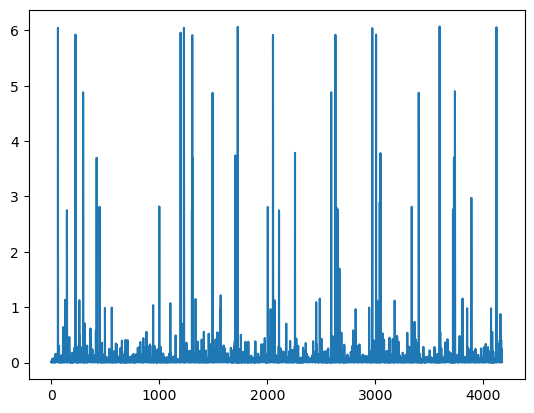

{'TEST!': 1, 'batch': 0, 'loss': 0.004639075603336096}


KeyboardInterrupt: 

In [41]:
train(train_loader,test_loader,model,batch_size=batch_size,num_epochs=20)

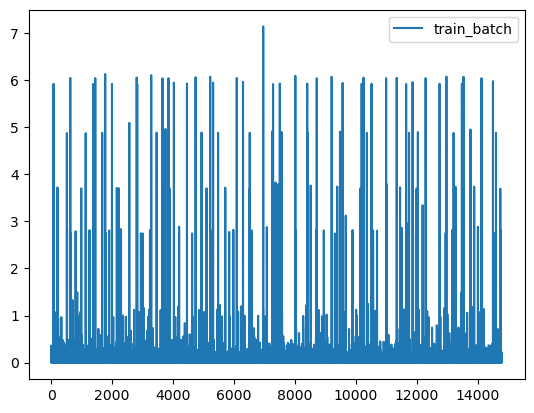

In [27]:
import matplotlib.pyplot as plt
plt.plot(batch_losses,label = "train_batch")
plt.legend()
plt.show()

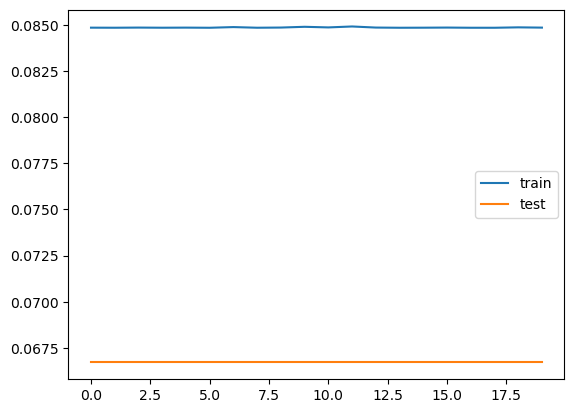

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label = "train")
plt.plot(test_losses, label = "test")
plt.legend()
plt.show()

Making the model more complex with a selfattention block.

In [23]:
class AttentionBlock(nn.Module):
    def __init__(self, key_dim, val_dim, query_dim, hidden_dim, num_heads,FC_hidden=500):
        super(AttentionBlock, self).__init__()
        self.key_gen = nn.Sequential(
            nn.Linear(key_dim,FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden,FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden, hidden_dim),
            nn.ReLU(),
        )

        self.val_gen = nn.Sequential(
            nn.Linear(val_dim, FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden, FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden, hidden_dim),
            nn.ReLU(),
        )
        
        self.query_gen = nn.Sequential(
            nn.Linear(query_dim, FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden, FC_hidden),
            nn.ReLU(),
            nn.Linear(FC_hidden, hidden_dim),
            nn.ReLU(),
        )
        self.multihead_attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
    
    def forward(self,keys,values,queries):
        key = self.key_gen(keys) #generate key with FC key is directly the embedding
        value = self.val_gen(values) #generate value with FC
        query = self.query_gen(queries) #generate query with FC
        output, _ =  self.multihead_attn(key=key, value=value, query=query)
        return output

In [24]:
class SelfAtt_model(nn.Module):
    def __init__(self, systreat_dim,species_dim, conditions_dim, hidden_dim, output_dim):
        super(SelfAtt_model, self).__init__()
        self.rel = nn.ReLU()
        self.embedding_systreat = nn.Embedding(num_embeddings=systreat_dim,embedding_dim=hidden_dim) 
        self.embedding_specie = nn.Embedding(num_embeddings=species_dim,embedding_dim=hidden_dim) 
        self.conditions_fc = nn.Linear(conditions_dim,hidden_dim)
        self.selfatt = AttentionBlock(hidden_dim*3,hidden_dim*3,hidden_dim*3,hidden_dim,num_heads=1)
        self.fc_reg = nn.Linear(hidden_dim,output_dim) 
        
        
    def forward(self, onehot_specie,onehot_systreat, condits):
        emb = self.embedding_systreat(onehot_systreat)
        emb1 = self.embedding_specie(onehot_specie)
        data_enc = self.conditions_fc(condits)
        data_enc = self.rel(data_enc)
        
        out = torch.cat((emb,emb1,data_enc),dim=-1)
        out = self.selfatt(out,out,out)
        out = self.fc_reg(out)
        out = self.rel(out)

        return out

In [25]:
model = SelfAtt_model(systreat_dim = len(dataset.combinations),
                    species_dim= len(dataset.species_vocab),
                    conditions_dim = len(columns),
                     hidden_dim=512, 
                     output_dim = 1)

In [26]:
model = model.to(device)

In [46]:
from torchviz import make_dot
from torchsummary import summary


specie_onehot , systreat_onehot, data, y = dataset.__getitem__(6)

specie_onehot = specie_onehot.to(device).unsqueeze(0)
systreat_onehot = systreat_onehot.to(device).unsqueeze(0)
data = data.to(device).unsqueeze(0)

input_sizes = [
    (specie_onehot.size(0), systreat_onehot.size(0), data.size(0))
]
summary(model, (1, 28, 28))

TypeError: SelfAtt_model.forward() missing 2 required positional arguments: 'onehot_systreat' and 'condits'

In [31]:
!pip install torchsummary

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [28]:
train_losses = []
test_losses = []
batch_losses = []

In [29]:
lr = 0.00001

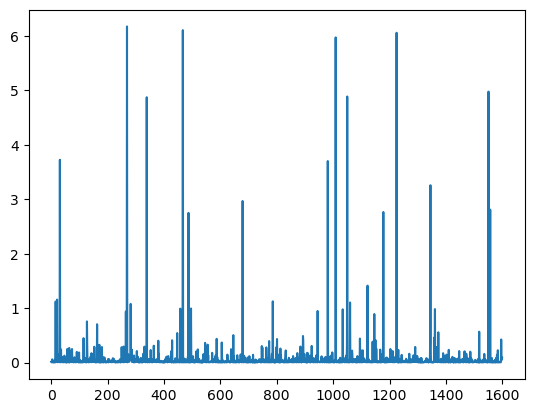

KeyboardInterrupt: 

In [30]:
train(train_loader,test_loader,model,batch_size=batch_size,num_epochs=20)

In [50]:
import json
with open("project.ipynb") as pynb:
    try:
        report = json.load(pynb)
    except Exception as e:
        print(str(e))

Expecting property name enclosed in double quotes: line 586 column 4 (char 237842)


In [49]:
import nbformat

# Load the notebook file
notebook_file_path = 'project.ipynb'

with open(notebook_file_path, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Process and validate the cells
valid_cells = []

for cell in notebook_content.cells:
    if cell.cell_type in {'code', 'markdown'}:
        valid_cells.append(cell)

# Create a new valid Jupyter Notebook file
new_notebook = nbformat.v4.new_notebook(cells=valid_cells)

# Save the corrected Jupyter Notebook file
new_notebook_file_path = 'corrected_project.ipynb'

with open(new_notebook_file_path, 'w', encoding='utf-8') as f:
    nbformat.write(new_notebook, f)

print(f"Corrections made and saved to {new_notebook_file_path}")

NotJSONError: Notebook does not appear to be JSON: '{\n    "cells": [\n     {\n      "cell_...